https://towardsdatascience.com/learning-reinforcement-learning-reinforce-with-pytorch-5e8ad7fc7da0

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

With our packages imported, we’re going to set up a simple class called policy_estimator that will contain our neural network. It’s going to have two hidden layers with a ReLU activation function and softmax output. We’ll also give it a method called predict that enables us to do a forward pass through the network.

In [2]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16), 
            nn.ReLU(), 
            nn.Linear(16, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

One thing I’ve done here that’s a bit non-standard is subtract the mean of the rewards at the end. This helps to stabilize the learning, particularly in cases such as this one where all the rewards are positive because the gradients change more with negative or below-average rewards than they would if the rewards weren’t normalized like this.

In [3]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()



Now for the REINFORCE algorithm itself. A few points on the implementation, always be certain to ensure your outputs from PyTorch are converted back to NumPy arrays before you pass the values to env.step() or functions like np.random.choice() to avoid errors. Also, we use torch.gather() to separate the actual actions taken from the action probabilities to ensure we’re calculating the loss function properly as discussed above. Finally, you can change the ending so that the algorithm stops running once the environment is “solved” instead of running for a preset number of steps (CartPole is solved after an average score of 195 or more for 100 consecutive episodes).

The DQN gives us estimates of the discounted future rewards of the state and we make our selection based on these values (typically taking the maximum value according to some ϵ-greedy rule). The policy gradient, on the other hand, gives us probabilities of our actions. The way we make our selection, in this case, is by choosing action 0 x% of the time and action 1 y% of the time. These probabilities will change as the network gains more experience.

In [8]:
def reinforce(env, policy_estimator, num_episodes=2000, batch_size=10, gamma=0.99):
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.01)
    
    # Setup discrete Action space
    action_space = np.arange(env.action_space.n)
    ep = 0
    
    while ep < num_episodes:
        # get the initial observed state (start a new game)
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        
        while done == False:
            # Get action probabilities and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            # chiise action based on probabilities
            action = np.random.choice(action_space, p=action_probs)
            # execute action in the environment
            s_1, r, done, _ = env.step(action)

            # keep the trajectory of state, reward and actions
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            
            # update the last state to the current state after we executed the action
            s_0 = s_1
            
            # If done, batch data
            if done:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(
                        batch_rewards)
                    # Actions are used as indices, must be 
                    # LongTensor
                    action_tensor = torch.LongTensor(
                       batch_actions)
                    
                    # Calculate loss
                    logprob = torch.log(policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * torch.gather(logprob, 1, action_tensor.unsqueeze(1)).squeeze()
                    loss = -selected_logprobs.mean()
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-100:])
                # Print running average
                print(f"Ep: {ep + 1} Average of last 100: {avg_rewards:.2f}")
                ep += 1
                
    return total_rewards

To run this, we just need a few lines of code to put it all together.

In [9]:
env = gym.make('CartPole-v0')
policy_est = policy_estimator(env)
rewards = reinforce(env, policy_est)

Ep: {} Average of last 100:2000.00

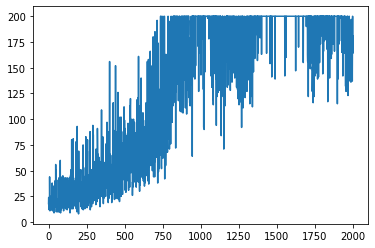

In [14]:
plt.plot(rewards)

In [20]:
import json

json.loads('''
{"Value":[{"FinanceId":"1234","Stage":"TEST","StackTrace":null,"Message":"something bad happened","Data":{},"InnerException":null,"HelpLink":null,"Source":null,"HResult":-2146233088}],"Formatters":[],"ContentTypes":[],"DeclaredType":null,"StatusCode":400}
''')

{'Value': [{'FinanceId': '1234',
   'Stage': 'TEST',
   'StackTrace': None,
   'Message': 'something bad happened',
   'Data': {},
   'InnerException': None,
   'HelpLink': None,
   'Source': None,
   'HResult': -2146233088}],
 'Formatters': [],
 'ContentTypes': [],
 'DeclaredType': None,
 'StatusCode': 400}